In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [ ]:
# Standard imports for data manipulation and visualization
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
sns.set_theme(style="whitegrid")

import copy
import numpy as np
import math

# Statistical distributions and functions
from scipy.stats import norm, \
    beta, cauchy, expon, rayleigh, uniform, multivariate_t, t, \
    rankdata, kendalltau, pearsonr
from scipy.stats.mstats import spearmanr
import scipy.integrate as integrate

# Data handling
import pandas as pd

# Time series modeling
import prophet

# Financial data
import yfinance as yf

# Optimization
from scipy.optimize import brentq, fsolve

# Vine copula library
import pyvinecopulib as pv

# Lesson 10: Vine Copula Inference

In this lesson, we learn how to perform **conditional inference** using vine copulas. This is one of the most powerful applications of copulas: computing conditional distributions to answer questions like "Given that Bitcoin returns are high, what is the distribution of Ethereum returns?"

**Learning Objectives:**
1. Understand the general inference problem for multivariate distributions
2. Learn the Rosenblatt transform for computing conditional distributions
3. Apply the Rosenblatt transform to a fitted vine copula
4. Visualize and interpret conditional distributions

---

## 1. The General Inference Problem

Given a multivariate distribution, we often want to compute conditional probabilities:

$$P(\mathbf{Y} \leq \mathbf{y} \mid \mathbf{X} = \mathbf{x})$$

For example:
- What is the distribution of ETH returns given BTC returns are in the 75th percentile?
- What is the distribution of FIL returns given both BTC and ETH returns are known?

---

## 2. The Rosenblatt Transform

The **Rosenblatt transform** is a key tool for computing conditional distributions from a copula. It transforms a vector of uniform random variables $\mathbf{U}$ into another vector $\mathbf{V}$ of independent uniform random variables.

Given $\mathbf{U} = (U_1, U_2, \ldots, U_d)$ with copula $C$, the Rosenblatt transform produces:

$$\mathbf{V} = (V_1, V_2, \ldots, V_d) = R(\mathbf{U})$$

### 2.1 Definition of the Rosenblatt Transform

The transform is defined recursively using conditional CDFs:

$$ V_j = C_{j|j-1,\ldots,1}(U_j \mid U_{j-1}, \ldots, U_1) $$

More explicitly:
- $V_1 = C_1(U_1) = U_1$ (the first variable is unchanged)
- $V_2 = C_{2|1}(U_2 \mid U_1)$ (conditional CDF of $U_2$ given $U_1$)
- $V_3 = C_{3|2,1}(U_3 \mid U_2, U_1)$ (conditional CDF of $U_3$ given $U_2, U_1$)
- And so on...

**Key Insight:** If the copula model is correct, the transformed variables $V_j$ should be independent $\text{Uniform}(0,1)$ random variables.

**For Inference:** By fixing some $U$ values and varying others, we can compute conditional distributions!

---

## 3. Practical Example: Cryptocurrency Conditional Distributions

We'll use the same cryptocurrency data from Lesson 9 to demonstrate conditional inference.

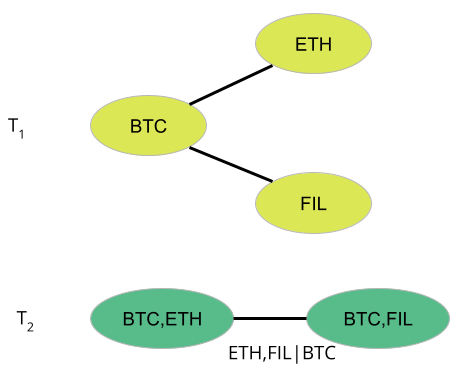

In [3]:
display.Image("crypto_vine_example.png")

In [ ]:
### 3.1 Load and Prepare Data

# Define cryptocurrency tickers
tickers = ['BTC-USD', 'ETH-USD', 'FIL-USD']

# Download historical price data
data = yf.download(' '.join(tickers), start="2021-01-01", end="2023-12-31")

In [ ]:
# Extract adjusted closing prices and compute log returns
close_prices = data['Adj Close']
returns_data = np.log1p(close_prices.pct_change())
returns_data = returns_data.reset_index().rename(columns={'Date': 'ds'})
returns_data['ds'] = pd.to_datetime(returns_data['ds']).dt.tz_localize(None)

# Visualize the data
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
for tick in tickers:
    plt.plot(close_prices[tick], label=tick)
plt.xticks(rotation=60)
plt.title('Closing Price (Log Scale)')
plt.yscale('log')
plt.legend()

plt.subplot(1,2,2)
for tick in tickers:
    plt.plot(returns_data['ds'], returns_data[tick], label=tick)
plt.xticks(rotation=60)
plt.title('Log Returns')

plt.tight_layout()

In [ ]:
### 3.2 Fit Prophet Models and Extract Residuals

tick2data = {}
tick2model = {}

for tick in tickers:
    # Fit Prophet model to capture time-series patterns
    m = prophet.Prophet()
    df = returns_data[['ds', tick]].rename(columns={tick: 'y'})
    m.fit(df)
    
    # Compute residuals
    df_forecast = m.predict()
    df = pd.merge(df, df_forecast, on='ds')
    df['residual'] = df['y'] - df['yhat']

    tick2data[tick] = df
    tick2model[tick] = m

In [ ]:
# Visualize residuals and their relationships
plt.figure(figsize=(9,4))

plt.subplot(1,3,1)
for tick in tickers:
    df = tick2data[tick]
    plt.plot(df['ds'], df['residual'], label=tick)
plt.xticks(rotation=60)
plt.legend()
plt.title('Model Prediction Residuals')

center_tick = 'BTC-USD'
remaining_tickers = copy.copy(tickers)
remaining_tickers.remove(center_tick)

plt.subplot(1,3,2)
plt.scatter(tick2data[center_tick]['residual'], tick2data['ETH-USD']['residual'], alpha=0.4)
plt.xlabel(center_tick)
plt.ylabel('ETH-USD')
plt.title('BTC vs ETH')

plt.subplot(1,3,3)
plt.scatter(tick2data[center_tick]['residual'], tick2data['FIL-USD']['residual'], alpha=0.4)
plt.xlabel(center_tick)
plt.ylabel('FIL-USD')
plt.title('BTC vs FIL')

plt.tight_layout()

In [ ]:
### 3.3 Transform to Pseudo-Observations and Fit Copula

# Create DataFrame of residuals
X = pd.DataFrame()
X['btc_residual'] = tick2data['BTC-USD']['residual'] 
X['eth_residual'] = tick2data['ETH-USD']['residual'] 
X['fil_residual'] = tick2data['FIL-USD']['residual']

# Convert to pseudo-observations (empirical CDF values in [0,1])
U = pv.to_pseudo_obs(X)

In [ ]:
# Visualize pairwise pseudo-observations
plt.figure(figsize=(9,4))

plt.subplot(1,3,1)
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.xlabel('U (BTC)')
plt.ylabel('U (ETH)')

plt.subplot(1,3,2)
plt.scatter(U[:,0], U[:,2], alpha=0.5)
plt.xlabel('U (BTC)')
plt.ylabel('U (FIL)')

plt.subplot(1,3,3)
plt.scatter(U[:,1], U[:,2], alpha=0.5)
plt.xlabel('U (ETH)')
plt.ylabel('U (FIL)')

plt.tight_layout()

In [ ]:
# Fit C-Vine copula
# Order: [3,2,1] means FIL(3), ETH(2), BTC(1)
cop = pv.Vinecop(data=U, 
                 structure=pv.CVineStructure([3,2,1]))

In [ ]:
# Display the fitted copula structure
print("Fitted Vine Copula:")
print(cop)

In [ ]:
# Check the copula order
# This tells us the ordering of variables in the vine structure
print("Copula variable order:", cop.order)

---

## 4. Computing Conditional Distributions

With a C-Vine structure, we can compute the following conditional distributions:

| Distribution | Interpretation |
|--------------|----------------|
| $P(U_1 \leq u_1)$ | Marginal distribution of BTC (trivially uniform) |
| $P(U_2 \leq u_2 \mid U_1 = u_1)$ | ETH given BTC |
| $P(U_3 \leq u_3 \mid U_2 = u_2, U_1 = u_1)$ | FIL given ETH and BTC |

**Note:** The copula order determines which conditionals we can compute directly!

### 4.1 Compute $P(U_2 \mid U_1 = u_1)$: ETH given BTC

Let's compute the distribution of ETH returns given that BTC returns are at the 75th percentile.

In [ ]:
# IMPORTANT: Input to rosenblatt() is ALWAYS in order [u1, u2, u3, ...]
# regardless of the copula's internal ordering.
# See: https://github.com/vinecopulib/pyvinecopulib/issues/104

nn = 100  # Number of points to evaluate

# Create input matrix:
# - Column 0 (U1 = BTC): Fixed at 0.75 (75th percentile)
# - Column 1 (U2 = ETH): Varies from 0 to 1 (we want this distribution)
# - Column 2 (U3 = FIL): Also varies (but we'll focus on column 1 output)
u_sim = np.vstack([
    0.75 * np.ones(nn),        # BTC fixed at 75th percentile
    np.linspace(0, 1, nn),     # ETH varies
    np.linspace(0, 1, nn),     # FIL varies (placeholder)
]).T

print(f"Input shape: {u_sim.shape}")
print(f"BTC (U1) fixed at: {u_sim[0, 0]}")

In [ ]:
# Apply the Rosenblatt transform
# Output is ALWAYS in order [v1, v2, v3, ...] regardless of copula ordering
v_sim = cop.rosenblatt(u_sim)

# v_sim[:,1] gives us P(U2 <= u2 | U1 = 0.75)
# If the copula correctly models the dependence, v_sim[:,1] should represent
# the conditional CDF values

In [ ]:
# Visualize the conditional distribution
# We use quantile transformation to convert back to the original scale

plt.figure(figsize=(8,4))

# Left plot: Distribution in copula space (uniform scale)
plt.subplot(1,2,1)
sns.histplot(v_sim[:,1], kde=True, bins=30)
plt.xlabel(r'$V_2$ (transformed ETH)')
plt.ylabel('Density')
plt.title(r'$P(U_2 \mid U_1 = %0.2f)$ in Copula Space' % (u_sim[0,0],))

# Right plot: Distribution in original scale (residuals)
plt.subplot(1,2,2)
x1 = np.quantile(X['btc_residual'].to_numpy(), u_sim[0,0])
eth_conditional = np.quantile(X['eth_residual'].to_numpy(), v_sim[:,1])
sns.histplot(eth_conditional, kde=True, bins=30)
plt.xlabel('ETH Residual')
plt.ylabel('Density')
plt.title(r'$P(X_2 \mid X_1 = %0.4f)$' % (x1,))

plt.tight_layout()

### 4.2 Compute $P(U_3 \mid U_2 = u_2, U_1 = u_1)$: FIL given ETH and BTC

Now let's compute the distribution of FIL returns given that both BTC and ETH returns are at the 75th percentile.

In [ ]:
# For P(U3 | U2 = u2, U1 = u1), we fix both BTC and ETH
nn = 100

u_sim = np.vstack([
    0.75 * np.ones(nn),        # BTC fixed at 75th percentile
    0.75 * np.ones(nn),        # ETH fixed at 75th percentile
    np.linspace(0, 1, nn),     # FIL varies (this is what we want)
]).T

print(f"Input shape: {u_sim.shape}")
print(f"BTC (U1) fixed at: {u_sim[0, 0]}")
print(f"ETH (U2) fixed at: {u_sim[0, 1]}")

In [ ]:
# Apply Rosenblatt transform
v_sim = cop.rosenblatt(u_sim)

# v_sim[:,2] gives us P(U3 <= u3 | U2 = 0.75, U1 = 0.75)

In [ ]:
# Visualize the conditional distribution of FIL given BTC and ETH

plt.figure(figsize=(8,4))

# Left plot: Distribution in copula space
plt.subplot(1,2,1)
sns.histplot(v_sim[:,2], kde=True, bins=30)
plt.xlabel(r'$V_3$ (transformed FIL)')
plt.ylabel('Density')
plt.title(r'$P(U_3 \mid U_2 = %0.2f, U_1 = %0.2f)$' % (u_sim[0,1], u_sim[0,0]))

# Right plot: Distribution in original scale
plt.subplot(1,2,2)
x1 = np.quantile(X['btc_residual'].to_numpy(), u_sim[0,0])
x2 = np.quantile(X['eth_residual'].to_numpy(), u_sim[0,1])
fil_conditional = np.quantile(X['fil_residual'].to_numpy(), v_sim[:,2])
sns.histplot(fil_conditional, kde=True, bins=30)
plt.xlabel('FIL Residual')
plt.ylabel('Density')
plt.title(r'$P(X_3 \mid X_2 = %0.4f, X_1 = %0.4f)$' % (x2, x1))

plt.tight_layout()